In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
analysis_df = pd.read_pickle('../pkl_files/analysis_df.pkl')
analysis_x = analysis_df.drop(['ponv', 'vomiting24h'], axis=1)
analysis_y = analysis_df['ponv']

In [3]:
# Extract Test Set
tv_x, test_x, tv_y, test_y = train_test_split(analysis_x, analysis_y, test_size=.2, random_state=10)
train_x, val_x, train_y, val_y = train_test_split(tv_x, tv_y, test_size=.25, random_state=444)

In [4]:
import log_reg_tuning as lrt
import Extract_feats_PONV as efp

In [5]:
train_input = efp.total_drug_interaction(analysis_df, tv_x)

/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/jpnb/Extract_feats_PONV.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_plus_FE['tot_drugs'] = input_plus_FE[['tramadol_dose_pacu', 'ketamine_dose',


In [6]:
final_model = lrt.ponv_log_reg(train_input, tv_y) 

Avg. f1 score: 0.5057639987698459
Avg. Roc/Auc score 0.6733120109923995


In [7]:
final_model.coef_

array([[ 0.24727741,  0.2882728 ,  0.32499507,  0.07249045,  0.02541421,
        -0.03084377,  0.01111237,  0.11339319, -0.02723381, -0.10683753,
        -0.06617614, -0.03931586,  0.02421246, -0.12860762, -0.02566572,
        -0.10585641, -0.15603081, -0.12932098, -0.09833735, -0.0733003 ,
        -0.14864069, -0.35290005,  0.01736669, -0.23260759, -0.01005653,
        -0.10203835, -0.0145543 , -0.10424377, -0.03259067,  0.33480406,
        -0.18539375, -0.25186567,  0.03588335, -0.12965906,  0.07879517,
         0.17083813,  0.08407194, -0.02461652]])

In [8]:
val_input = efp.total_drug_interaction(analysis_df, val_x)

/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/jpnb/Extract_feats_PONV.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_plus_FE['tot_drugs'] = input_plus_FE[['tramadol_dose_pacu', 'ketamine_dose',


In [9]:
val_x_sc = lrt.std_scale(train_input, val_input)[1]

In [10]:
final_model.predict(val_x_sc)

array([ True,  True,  True, False,  True, False, False, False, False,
       False, False, False,  True, False,  True,  True, False,  True,
        True,  True, False,  True, False,  True, False,  True, False,
       False,  True, False, False,  True,  True,  True, False,  True,
        True,  True, False,  True, False,  True,  True, False, False,
        True, False,  True, False, False, False, False, False,  True,
       False,  True,  True,  True,  True, False, False, False,  True,
       False,  True,  True, False,  True, False, False,  True,  True,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
       False, False, False,  True, False,  True,  True,  True,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True, False, False,  True, False, False,
       False,  True,

In [11]:
confusion_matrix(val_y, final_model.predict(val_x_sc))


array([[150, 116],
       [ 28,  83]])

In [12]:
f1_score(val_y, final_model.predict(val_x_sc))

0.5354838709677419

Logistic Regression Model best F1 score 0.538 at prob decision threshold >= 0.498


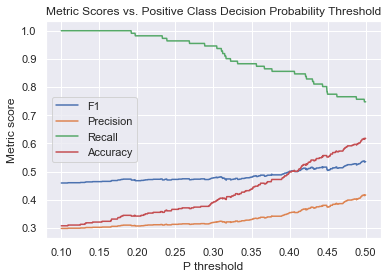

In [13]:
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = final_model.predict_proba(val_x_sc)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(val_y, model_val_labels))    
    prec_scores.append(precision_score(val_y, model_val_labels))
    rec_scores.append(recall_score(val_y, model_val_labels))
    acc_scores.append(accuracy_score(val_y, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [14]:
import pickle
pickle.dump(final_model, open('lr_pickled_model.p', 'wb'))

'solver':['liblinear', 'saga'],\
'penalty': ['l1', 'l2'],\
'tol': (1e-6, 100, 'log-uniform'),\
'C': (1e-6, 100, 'log-uniform'),\
'fit_intercept': [True, False]\
LogisticRegression(C=100, penalty='l1', solver='liblinear', tol=1e-06)

# GridSearchCV hypertuning

In [15]:
param_grid = {
    'solver':['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'tol': (1e-6, 100, 'log-uniform'),
    'C': (1e-6, 100, 'log-uniform'),
    'fit_intercept': [True, False]
}
clf = GridSearchCV(final_model, param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)
best_clf = clf.fit(train_input, tv_y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   22.7s finished


In [16]:
best_clf.best_estimator_

LogisticRegression(C=1e-06, class_weight={0: 1, 1: 2}, max_iter=1000,
                   penalty='l1', solver='liblinear', tol=100)

In [17]:
dict(zip(train_input.columns,final_model.coef_[0]))

{'gender_code': 0.24727740990286226,
 'non_smoker': 0.28827279728232363,
 'previous_ponv': 0.32499507213472517,
 'postoperative_opioids': 0.07249045430982205,
 'pancreatectomy': 0.025414207147910203,
 'hysterectomy_vlp': -0.030843768142270734,
 'anexectomy_ovariectomy': 0.011112367527613817,
 'cystectomy': 0.11339319106953816,
 'extensive_lymphadenectomy': -0.027233807915637127,
 'plastic': -0.10683752998795612,
 'cytoreduction': -0.06617614215775872,
 'hysterectomy': -0.03931585976115815,
 'nephrectomy': 0.02421246059396368,
 'mastectomy': -0.12860762479045323,
 'thoracic': -0.025665724737803007,
 'exploratory_laparotomy': -0.10585640847219657,
 'hepatectomy': -0.15603081479788802,
 'prostatectomy': -0.1293209842478553,
 'breast_lumpectomy': -0.09833735134163599,
 'spine_surgery': -0.07330030353097804,
 'head_neck': -0.1486406855706709,
 'orthopedic': -0.35290005176868705,
 'fentanil_mcg': 0.017366691507636048,
 'sufentanil_mcg': -0.23260758535964152,
 'tramadol_dose_pacu': -0.0100565

# Predict on Test

In [18]:
test_input = efp.total_drug_interaction(analysis_df, test_x)

/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/jpnb/Extract_feats_PONV.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_plus_FE['tot_drugs'] = input_plus_FE[['tramadol_dose_pacu', 'ketamine_dose',


In [19]:
test_input_sc = lrt.std_scale(train_input, test_input)[1]

In [20]:
final_soft = final_model.predict_proba(test_input_sc)
final_hard = final_model.predict(test_input_sc)
final_cm = confusion_matrix(test_y, final_hard)

In [21]:
f1_score(test_y, final_hard)

0.46416382252559724

In [22]:
final_cm

array([[152, 113],
       [ 44,  68]])

# Apfel Output

In [23]:
import baseline_apfel as apfel

In [24]:
apfel_output = apfel.apfel_prob(test_x, test_y)

/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/jpnb/baseline_apfel.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apfel_output['apfel_prob'] = apfel_output['apfel'].map({0: .1, 1: .2, 2: .4, 3: .6, 4: .8})
/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/jpnb/baseline_apfel.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apfel_output['apfel_pred'] = apfel_output['apfel_prob'].ap

In [25]:
confusion_matrix(apfel_output['actual'], apfel_output['apfel_pred'])

array([[172,  93],
       [ 49,  63]])

In [26]:
f1_score(apfel_output['actual'], apfel_output['apfel_pred'])

0.47014925373134325